In [2]:
import numpy as np
import pandas as pd
from pathlib import Path
import os.path
import matplotlib.pyplot as plt
from IPython.display import Image, display

import matplotlib.cm as cm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf 

from tensorflow.keras import Sequential, Input, layers, Model
from tensorflow.keras.layers import Dropout, MaxPool2D, Conv2D, BatchNormalization, MaxPooling2D, Dense, Flatten, InputLayer, Activation, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.applications.vgg19 import VGG19, preprocess_input

from tensorflow.keras.preprocessing import image

from imblearn.over_sampling import SMOTE 
from sklearn.metrics import confusion_matrix, classification_report

import os
from distutils.dir_util import copy_tree, remove_tree

In [3]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                    brightness_range=[0.9, 1.01],
                                    zoom_range=[.99, 1.01],
                                    horizontal_flip=True,
                                    fill_mode='constant')

In [4]:
base_dir = "../input/alzheimers-dataset-4-class-of-images/Alzheimer_s Dataset/"

# Define training directory 
training_data_dir = base_dir + "train/"
# Define testing directory
test_data_dir = base_dir + "test/"
# Create a project directory to combine both training and testing images in order to split them later.
project_dir = "./dataset/"

if os.path.exists(project_dir):
    remove_tree(project_dir)
os.mkdir(project_dir)
copy_tree(training_data_dir, project_dir)
copy_tree(test_data_dir, project_dir)

['./dataset/ModerateDemented/30.jpg',
 './dataset/ModerateDemented/29.jpg',
 './dataset/ModerateDemented/28.jpg',
 './dataset/ModerateDemented/32 (2).jpg',
 './dataset/ModerateDemented/27 (2).jpg',
 './dataset/ModerateDemented/31.jpg',
 './dataset/ModerateDemented/32.jpg',
 './dataset/ModerateDemented/30 (2).jpg',
 './dataset/ModerateDemented/29 (2).jpg',
 './dataset/ModerateDemented/27.jpg',
 './dataset/ModerateDemented/28 (2).jpg',
 './dataset/ModerateDemented/31 (2).jpg',
 './dataset/NonDemented/31 (51).jpg',
 './dataset/NonDemented/30 (84).jpg',
 './dataset/NonDemented/28 (25).jpg',
 './dataset/NonDemented/31 (100).jpg',
 './dataset/NonDemented/28 (28).jpg',
 './dataset/NonDemented/32 (63).jpg',
 './dataset/NonDemented/32 (65).jpg',
 './dataset/NonDemented/30 (31).jpg',
 './dataset/NonDemented/26 (92).jpg',
 './dataset/NonDemented/32 (32).jpg',
 './dataset/NonDemented/29 (32).jpg',
 './dataset/NonDemented/28 (98).jpg',
 './dataset/NonDemented/28 (92).jpg',
 './dataset/NonDemented/2

In [5]:
# Define the class names (that will be useful in order to match prediction while testing, to class labels later).

CLASSES = [ 'NonDemented',
            'VeryMildDemented',
            'MildDemented',
            'ModerateDemented']

# Define the image size (the images in this dataset are 176x176)

IMAGE_SIZE = [176, 176]

# Define a dimension tuple equal to the image size which will be used to load the picture using data generators
DIM = (176, 176)

In [6]:
all_data_gen = train_datagen.flow_from_directory(directory=project_dir, 
                                             target_size=DIM, 
                                             batch_size=6400,
                                             shuffle=False)

Found 6400 images belonging to 4 classes.


In [7]:
all_data_gen.class_indices

{'MildDemented': 0,
 'ModerateDemented': 1,
 'NonDemented': 2,
 'VeryMildDemented': 3}

In [8]:
training_data, training_labels = all_data_gen.next()

In [9]:
print("Training Data shape: " , training_data.shape)
print("Training Labels shape: " , training_labels.shape)

Training Data shape:  (6400, 176, 176, 3)
Training Labels shape:  (6400, 4)


In [10]:
import gc
gc.collect()

46

In [11]:
sm_resample = SMOTE(random_state=48)
training_data, training_labels = sm_resample.fit_resample(training_data.reshape(-1, 176 * 176 * 3), training_labels)
training_data = training_data.reshape(-1, 176, 176, 3)

print(training_data.shape, training_labels.shape)

(12800, 176, 176, 3) (12800, 4)


In [12]:
training_data, valid_data, training_labels, valid_labels = train_test_split(training_data, training_labels, test_size = 0.2, random_state=48)
training_data, test_data, training_labels, test_labels = train_test_split(training_data, training_labels, test_size = 0.1, random_state=48)

In [13]:
print("Training Data shape: " , training_data.shape)
print("Training Labels shape: " , training_labels.shape)
print("Validation Data shape: " , valid_data.shape)
print("Validation Labels shape: " , valid_labels.shape)
print("Testing Data shape: " , test_data.shape)
print("Testing Labels shape: " , test_labels.shape)

Training Data shape:  (9216, 176, 176, 3)
Training Labels shape:  (9216, 4)
Validation Data shape:  (2560, 176, 176, 3)
Validation Labels shape:  (2560, 4)
Testing Data shape:  (1024, 176, 176, 3)
Testing Labels shape:  (1024, 4)


In [17]:
gc.collect()

922

In [16]:
vgg19 = VGG19(input_shape=(176,176,3), weights='imagenet', include_top=False)
for layer in vgg19.layers:
    layer.trainable = False
flattenLayer = Flatten()(vgg19.output)
final_layer = Dense(4, activation='softmax')(flattenLayer)
modelvgg19 = Model(inputs=vgg19.input, outputs=final_layer)
modelvgg19.summary()

2022-08-19 21:56:53.135755: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-19 21:56:53.260282: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-19 21:56:53.261167: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-19 21:56:53.262932: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

80150528/80134624 [==============================] - 1s 0us/step
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 176, 176, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 176, 176, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 176, 176, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 88, 88, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 88, 88, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 88, 88, 128)       147584    
______________________________________________________________

In [18]:
import keras

In [19]:
modelvgg19.compile(optimizer='adam',
                   loss=tf.losses.CategoricalCrossentropy(),
                   metrics=[keras.metrics.AUC(name='auc'), keras.metrics.CategoricalAccuracy(name="acc"), keras.metrics.Recall(name="recall")])
callback = keras.callbacks.EarlyStopping(monitor='val_loss',
                                            patience=10,
                                            restore_best_weights=True)

In [20]:
gc.collect()

23

In [21]:
EPOCHS = 100
history = modelvgg19.fit(training_data, training_labels, validation_data=(valid_data, valid_labels), epochs=EPOCHS, callbacks=callback, verbose = 1)

2022-08-19 21:59:37.099984: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 3425697792 exceeds 10% of free system memory.
2022-08-19 21:59:40.840904: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 3425697792 exceeds 10% of free system memory.
2022-08-19 21:59:43.571309: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/100


2022-08-19 21:59:45.495933: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


288/288 [==============================] - ETA: 0s - loss: 0.8394 - auc: 0.8776 - acc: 0.6495 - recall: 0.5144

2022-08-19 22:00:07.875766: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 951582720 exceeds 10% of free system memory.
2022-08-19 22:00:09.199116: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 951582720 exceeds 10% of free system memory.


288/288 [==============================] - 31s 75ms/step - loss: 0.8394 - auc: 0.8776 - acc: 0.6495 - recall: 0.5144 - val_loss: 0.6032 - val_auc: 0.9403 - val_acc: 0.7469 - val_recall: 0.6566
Epoch 2/100
288/288 [==============================] - 19s 66ms/step - loss: 0.5698 - auc: 0.9440 - acc: 0.7587 - recall: 0.6948 - val_loss: 0.5138 - val_auc: 0.9551 - val_acc: 0.7824 - val_recall: 0.7137
Epoch 3/100
288/288 [==============================] - 19s 66ms/step - loss: 0.4802 - auc: 0.9608 - acc: 0.7987 - recall: 0.7458 - val_loss: 0.4674 - val_auc: 0.9633 - val_acc: 0.8027 - val_recall: 0.7656
Epoch 4/100
288/288 [==============================] - 19s 66ms/step - loss: 0.4137 - auc: 0.9720 - acc: 0.8343 - recall: 0.7877 - val_loss: 0.4146 - val_auc: 0.9723 - val_acc: 0.8297 - val_recall: 0.7859
Epoch 5/100
288/288 [==============================] - 19s 66ms/step - loss: 0.3844 - auc: 0.9755 - acc: 0.8473 - recall: 0.8108 - val_loss: 0.5174 - val_auc: 0.9531 - val_acc: 0.7703 - val_re

In [23]:
testing_score = modelvgg19.evaluate(test_data, test_labels)

32/32 [==============================] - 2s 55ms/step - loss: 0.1937 - auc: 0.9923 - acc: 0.9238 - recall: 0.9170


In [22]:
gc.collect()

1589

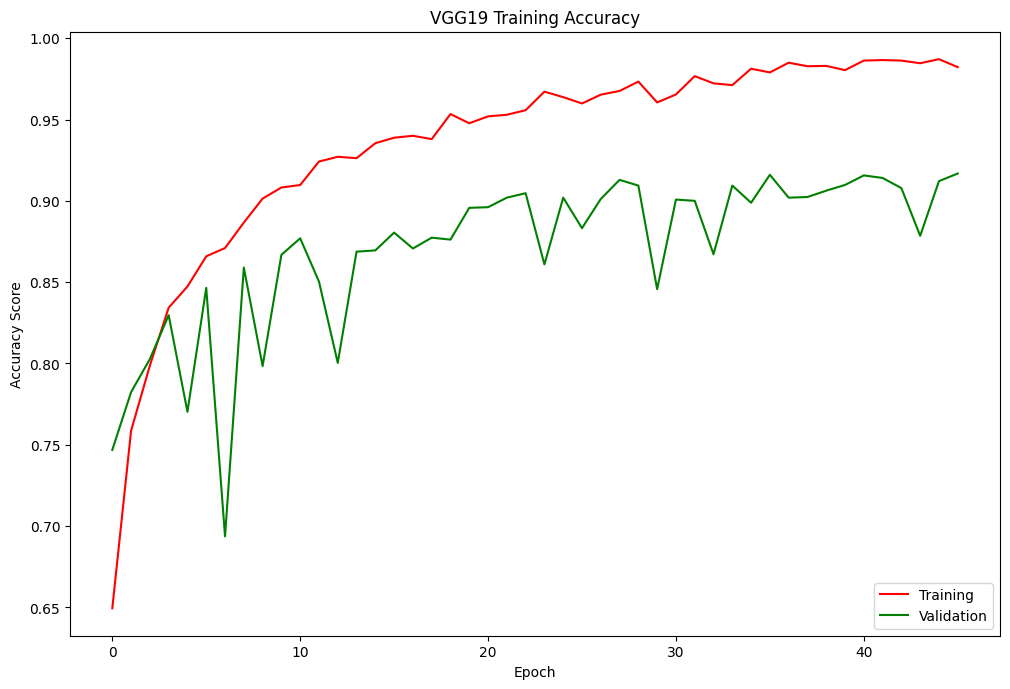

In [33]:
# Create a plot that visualises the training and validation accuracy over time
plt.figure(figsize=(12,8),  dpi=100)
plt.plot(history.history['acc'], "r")
plt.plot(history.history['val_acc'], "g")
plt.title('VGG19 Training Accuracy')
plt.ylabel('Accuracy Score')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='lower right')
plt.show()

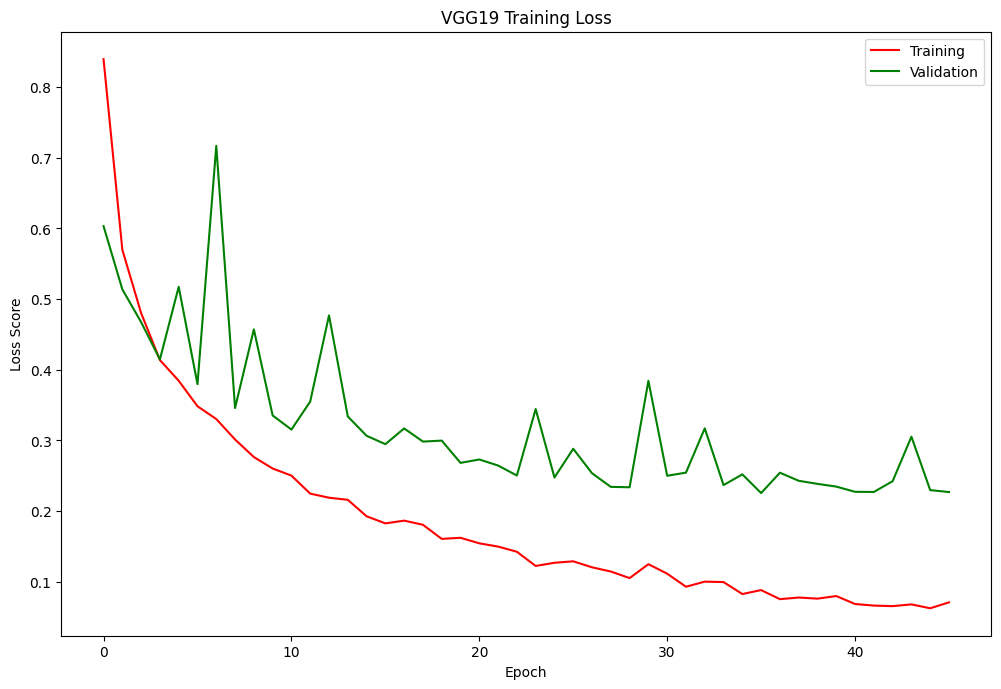

In [34]:
plt.figure(figsize=(12,8),  dpi=100)
plt.plot(history.history['loss'], "r")
plt.plot(history.history['val_loss'], "g")
plt.title('VGG19 Training Loss')
plt.ylabel('Loss Score')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

In [26]:
print("Testing Accuracy: ", (testing_score[1] * 100))

Testing Accuracy:  99.22960996627808


In [27]:
pred_labels = modelvgg19.predict(test_data)

In [28]:
def roundoff_preds(arr):
    arr[np.argwhere(arr != arr.max())] = 0
    arr[np.argwhere(arr == arr.max())] = 1
    return arr

for labels in pred_labels:
    labels = roundoff_preds(labels)

print(classification_report(test_labels, pred_labels, target_names=CLASSES))

                  precision    recall  f1-score   support

     NonDemented       0.94      0.98      0.96       258
VeryMildDemented       1.00      1.00      1.00       261
    MildDemented       0.92      0.84      0.88       273
ModerateDemented       0.82      0.88      0.85       232

       micro avg       0.92      0.92      0.92      1024
       macro avg       0.92      0.92      0.92      1024
    weighted avg       0.93      0.92      0.92      1024
     samples avg       0.92      0.92      0.92      1024



In [36]:
gc.collect()

799

In [29]:
training_score = modelvgg19.evaluate(training_data, training_labels)
print("Training Accuracy:" , (training_score[1] * 100))

2022-08-19 22:20:08.927617: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 3425697792 exceeds 10% of free system memory.


288/288 [==============================] - 15s 52ms/step - loss: 0.0629 - auc: 0.9999 - acc: 0.9929 - recall: 0.9911
Training Accuracy: 99.99105334281921


In [30]:
validation_score = modelvgg19.evaluate(valid_data, valid_labels)
print("Validation Accuracy: ", (validation_score[1] * 100))

80/80 [==============================] - 4s 51ms/step - loss: 0.2256 - auc: 0.9901 - acc: 0.9160 - recall: 0.9102
Validation Accuracy:  99.01150465011597


In [31]:
import seaborn as sns
pred_lbl = np.argmax(pred_labels, axis=1)
test_lbl = np.argmax(test_labels, axis=1)

conf_arr = confusion_matrix(test_lbl, pred_lbl)

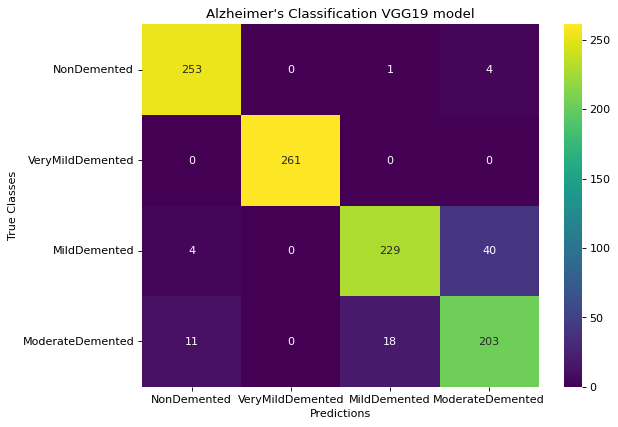

In [32]:
plt.figure(figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
ax = sns.heatmap(conf_arr, cmap='viridis', annot=True, fmt='d', xticklabels=CLASSES, yticklabels=CLASSES)
plt.title('Alzheimer\'s Classification VGG19 model')
plt.xlabel('Predictions')
plt.ylabel('True Classes')
plt.show(ax)

In [35]:
def get_img(img_path, size):
    # The img array will hold the selected image we want to produce explanations
    img = keras.preprocessing.image.load_img(img_path, target_size=size)
    array = keras.preprocessing.image.img_to_array(img)
    # The dimensions will transform the image array into an array with the shape (1, 176, 176, 3)
    array = np.expand_dims(array, axis=0)
    return array


def create_gradcam_map(img_array, model, last_conv_layer, pred_index=None):
    # This function creates a model that links the image to the model's activations of the last convolutional layer (before the dense layers),
    # and also connects the activations to the class predictions.
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer).output, model.output]
    )

    # The gradient tape is a tool that calculates the gradient (in this case the first class prediction), linked with the convolutional layer activations.
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_map = preds[:, pred_index]

    # Calculation of the output neuron gradient linked to the last convolutional layer output map
    neuron_grad = tape.gradient(class_map, last_conv_layer_output)

    # Calculating the gradient mean intensity of the output neuron gradient calculation
    pooled_grad = tf.reduce_mean(neuron_grad, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grad[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

In [43]:
modelvgg19.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 176, 176, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 176, 176, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 176, 176, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 88, 88, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 88, 88, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 88, 88, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 44, 44, 128)       0     

In [36]:
last_conv_layer = "block5_conv4"

In [37]:
def decode_prediction(classes):
    if classes == 0:
        print("Prediction: Mild Demented")
    elif classes == 1: 
        print("Prediction: Moderate Demented")
    elif classes == 2:
        print("Prediction: Non Demented")
    elif classes == 3:
        print("Prediction: Very Mild Demented")
    else: 
        print("There was an error. Please try again.")
    return decode_prediction

In [38]:
img_path = "/kaggle/working/dataset/MildDemented/27 (19).jpg"
img = image.load_img(img_path, target_size=(176, 176))

# Prepare image
img_array = preprocess_input(get_img(img_path, size=IMAGE_SIZE))

# Remove last layer's softmax
modelvgg19.layers[-1].activation = None
preds = modelvgg19.predict(img_array)
classes = np.argmax(preds, axis = 1)
decode_prediction(classes)

Prediction: Mild Demented


<function __main__.decode_prediction(classes)>

Prediction: Mild Demented


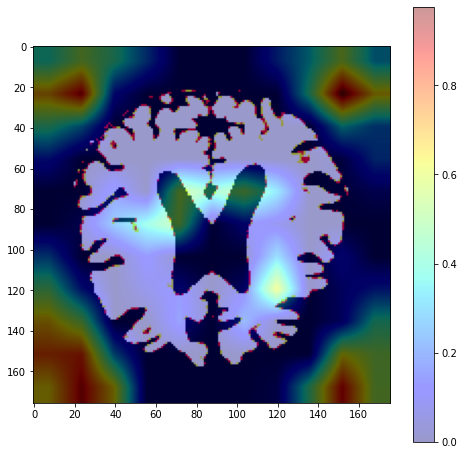

In [39]:
heatmap = create_gradcam_map(img_array, modelvgg19, last_conv_layer)

decode_prediction(classes)

plt.figure(figsize=(8,8))
plt.imshow(img_array[0])
plt.imshow(tf.image.resize(heatmap[...,np.newaxis], size=(img_array.shape[1], img_array.shape[2]))[:,:,0], alpha=0.4, cmap='jet')
plt.colorbar()
plt.show()

Prediction: Non Demented


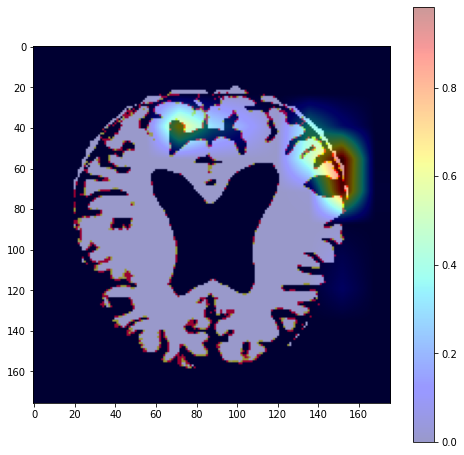

In [41]:
img_path = "/kaggle/working/dataset/MildDemented/27 (21).jpg"
img = image.load_img(img_path, target_size=(176, 176))

# Prepare image
img_array = preprocess_input(get_img(img_path, size=IMAGE_SIZE))

# Remove last layer's softmax
modelvgg19.layers[-1].activation = None
preds = modelvgg19.predict(img_array)
classes = np.argmax(preds, axis = 1)
decode_prediction(classes)
heatmap = create_gradcam_map(img_array, modelvgg19, last_conv_layer)

plt.figure(figsize=(8,8))
plt.imshow(img_array[0])
plt.imshow(tf.image.resize(heatmap[...,np.newaxis], size=(img_array.shape[1], img_array.shape[2]))[:,:,0], alpha=0.4, cmap='jet')
plt.colorbar()
plt.show()